#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature 가 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project3_1 폴더를 만들고, 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 라이브러리 로딩

* 라이브러리 로딩

In [556]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [559]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [563]:
train = pd.read_csv('data01_train.csv')

In [565]:
train.tail()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,SITTING
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,WALKING_UPSTAIRS
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,LAYING
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,WALKING_UPSTAIRS
5880,0.283815,-0.040658,-0.138018,-0.992662,-0.747190,-0.920248,-0.993410,-0.768055,-0.924587,-0.935871,...,-0.696584,0.107690,0.122242,-0.077226,-0.078091,-0.740244,0.008346,-0.146143,29,SITTING


In [567]:
test = pd.read_csv('data01_test.csv')
test.tail()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
1466,0.278725,-0.015262,-0.106398,-0.993625,-0.982845,-0.974745,-0.993963,-0.981100,-0.974596,-0.939303,...,-0.874066,-0.054788,0.712975,0.300318,-0.319188,-0.857336,0.120184,0.119276,14,SITTING
1467,0.275803,-0.019257,-0.109078,-0.998614,-0.991621,-0.987403,-0.998813,-0.991503,-0.986802,-0.945442,...,-0.721050,0.076333,-0.021599,-0.277268,0.754011,-0.764185,0.212111,0.138595,16,STANDING
1468,0.240402,0.006361,-0.121377,-0.045805,0.189930,0.332664,-0.114706,0.157771,0.195271,0.210139,...,-0.615554,0.330378,-0.667635,0.806563,-0.850113,-0.639564,0.185363,0.260201,8,WALKING_DOWNSTAIRS
1469,0.135873,-0.020675,-0.116644,-0.960526,-0.955134,-0.985818,-0.963115,-0.971338,-0.988261,-0.946289,...,-0.422383,-0.048474,0.236761,-0.186581,0.396648,0.790877,-0.474618,-0.505953,19,LAYING
1470,0.241563,-0.020145,-0.083858,0.410202,0.260990,-0.272913,0.345287,0.196325,-0.300247,0.622167,...,-0.843214,0.374865,0.509442,0.786957,-0.302746,-0.808984,0.193947,-0.076765,15,WALKING_DOWNSTAIRS


In [569]:
drop_cols = ['subject']
train.drop(columns = drop_cols,  axis=1,inplace = True)
train.tail()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.305772,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.622617,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.597610,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.196921,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS
5880,0.283815,-0.040658,-0.138018,-0.992662,-0.747190,-0.920248,-0.993410,-0.768055,-0.924587,-0.935871,...,-0.379740,-0.696584,0.107690,0.122242,-0.077226,-0.078091,-0.740244,0.008346,-0.146143,SITTING


In [571]:
drop_cols = ['subject']
test.drop(columns = drop_cols, axis=1, inplace = True)
test.tail()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
1466,0.278725,-0.015262,-0.106398,-0.993625,-0.982845,-0.974745,-0.993963,-0.981100,-0.974596,-0.939303,...,-0.586580,-0.874066,-0.054788,0.712975,0.300318,-0.319188,-0.857336,0.120184,0.119276,SITTING
1467,0.275803,-0.019257,-0.109078,-0.998614,-0.991621,-0.987403,-0.998813,-0.991503,-0.986802,-0.945442,...,-0.451941,-0.721050,0.076333,-0.021599,-0.277268,0.754011,-0.764185,0.212111,0.138595,STANDING
1468,0.240402,0.006361,-0.121377,-0.045805,0.189930,0.332664,-0.114706,0.157771,0.195271,0.210139,...,-0.213340,-0.615554,0.330378,-0.667635,0.806563,-0.850113,-0.639564,0.185363,0.260201,WALKING_DOWNSTAIRS
1469,0.135873,-0.020675,-0.116644,-0.960526,-0.955134,-0.985818,-0.963115,-0.971338,-0.988261,-0.946289,...,0.072602,-0.422383,-0.048474,0.236761,-0.186581,0.396648,0.790877,-0.474618,-0.505953,LAYING
1470,0.241563,-0.020145,-0.083858,0.410202,0.260990,-0.272913,0.345287,0.196325,-0.300247,0.622167,...,-0.567641,-0.843214,0.374865,0.509442,0.786957,-0.302746,-0.808984,0.193947,-0.076765,WALKING_DOWNSTAIRS


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [576]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [578]:
train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [579]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB


In [580]:
test.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [288]:
train['Activity']

0                 STANDING
1                   LAYING
2                 STANDING
3                  WALKING
4       WALKING_DOWNSTAIRS
               ...        
5876               SITTING
5877      WALKING_UPSTAIRS
5878                LAYING
5879      WALKING_UPSTAIRS
5880               SITTING
Name: Activity, Length: 5881, dtype: object

In [291]:
train['Activity'].value_counts(normalize = True).round(2)

Activity
LAYING                0.19
STANDING              0.18
SITTING               0.18
WALKING               0.17
WALKING_UPSTAIRS      0.15
WALKING_DOWNSTAIRS    0.13
Name: proportion, dtype: float64

In [292]:
test['Activity'].value_counts(normalize = True).round(2)

Activity
LAYING                0.20
STANDING              0.20
SITTING               0.17
WALKING               0.15
WALKING_UPSTAIRS      0.15
WALKING_DOWNSTAIRS    0.13
Name: proportion, dtype: float64

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [302]:
train.isna().sum()

tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
                                       ..
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
Activity                                0
Length: 562, dtype: int64

In [303]:
test.isna().sum()

tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
                                       ..
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
Activity                                0
Length: 562, dtype: int64

#### 2) 모델링

In [590]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
target = 'Activity'
x = train.drop(target, axis = 1)
y = train.loc[:, target]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3)
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [381]:
x.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.032207,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.246705,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.388765,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.050888,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.013902,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758


#### 3) 변수 중요도 추출

,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.029953
1,tGravityAcc-mean()-Y,0.028785
2,tGravityAcc-min()-X,0.028170
3,tGravityAcc-max()-Y,0.027130
4,"angle(Y,gravityMean)",0.026952
...,...,...
556,"fBodyAcc-bandsEnergy()-25,32.1",0.000083
557,tBodyAccJerk-mean()-X,0.000079
558,"fBodyAcc-bandsEnergy()-49,56",0.000079
559,fBodyAccJerk-iqr()-Y,0.000073


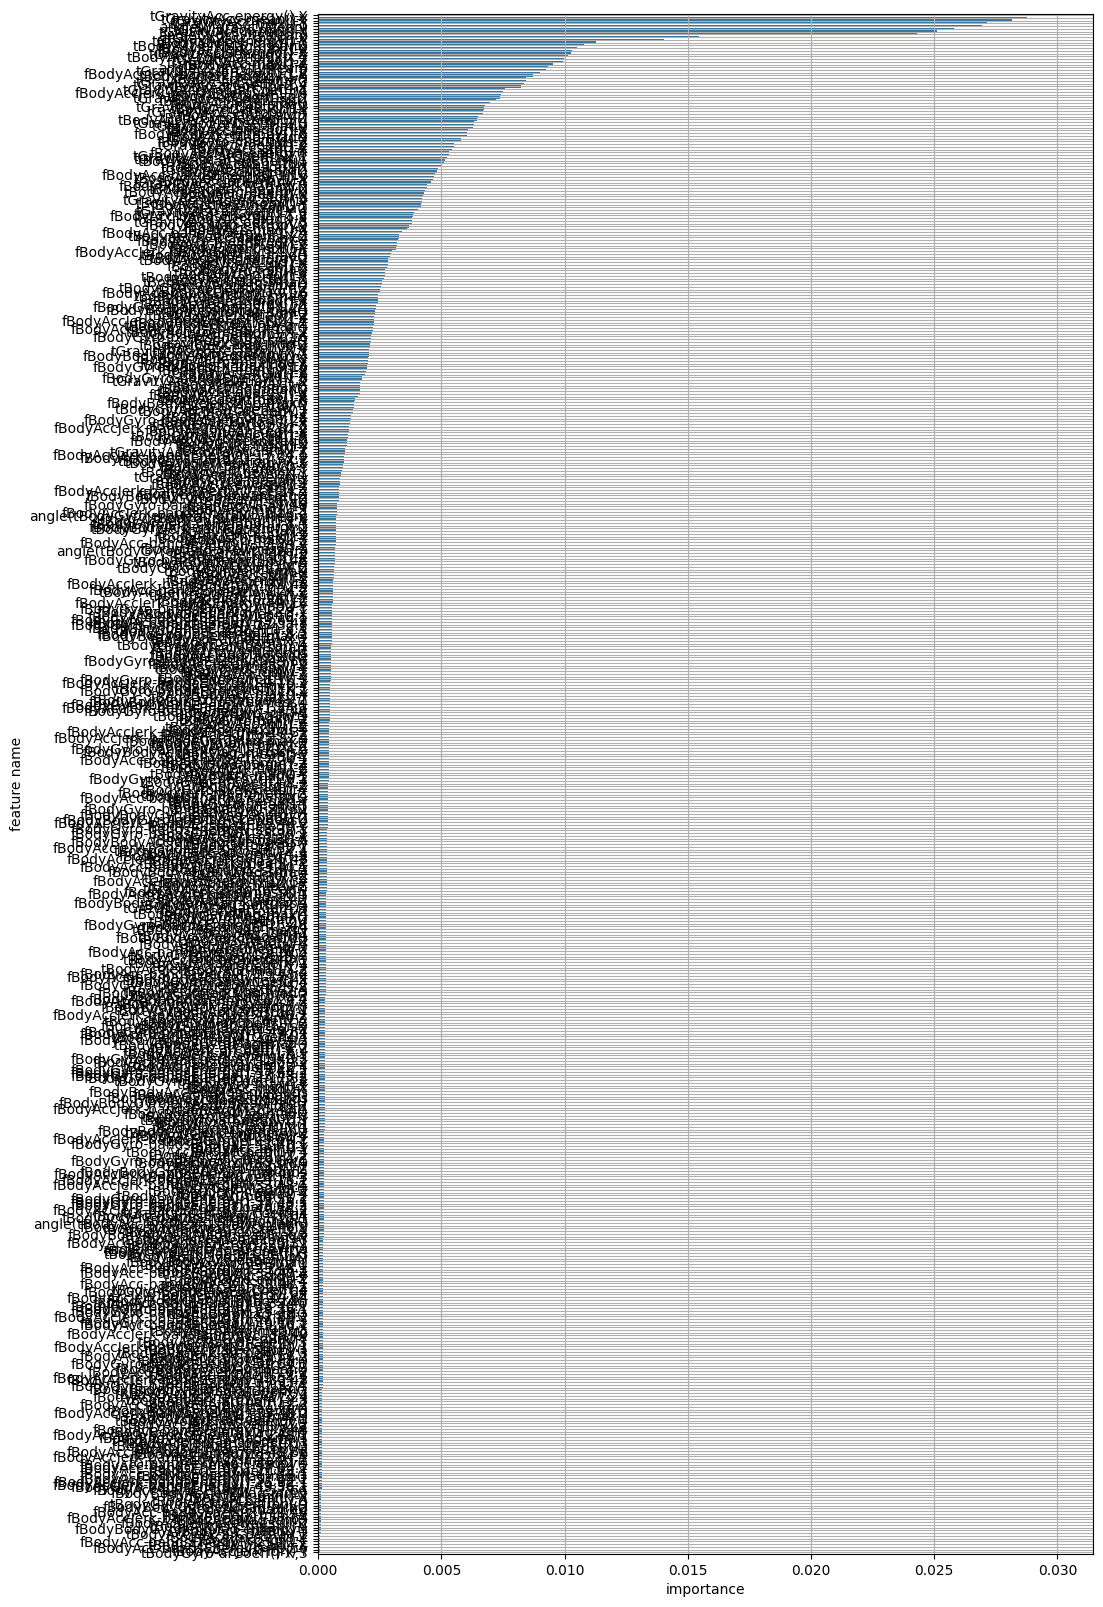

In [592]:
# 변수 중요도 추출
g1 = plot_feature_importance(model.feature_importances_, list(x_train), False)
g1

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [599]:
g1.head()

,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.029953
1,tGravityAcc-mean()-Y,0.028785
2,tGravityAcc-min()-X,0.028170
3,tGravityAcc-max()-Y,0.027130
4,"angle(Y,gravityMean)",0.026952


In [607]:
g1.tail(5)

,feature_name,feature_importance
556,"fBodyAcc-bandsEnergy()-25,32.1",0.000083
557,tBodyAccJerk-mean()-X,0.000079
558,"fBodyAcc-bandsEnergy()-49,56",0.000079
559,fBodyAccJerk-iqr()-Y,0.000073
560,"tBodyGyro-arCoeff()-X,3",0.000066


#### 2) 상위 5개 변수에 대한 분석

<Axes: xlabel='tGravityAcc-mean()-X', ylabel='Density'>

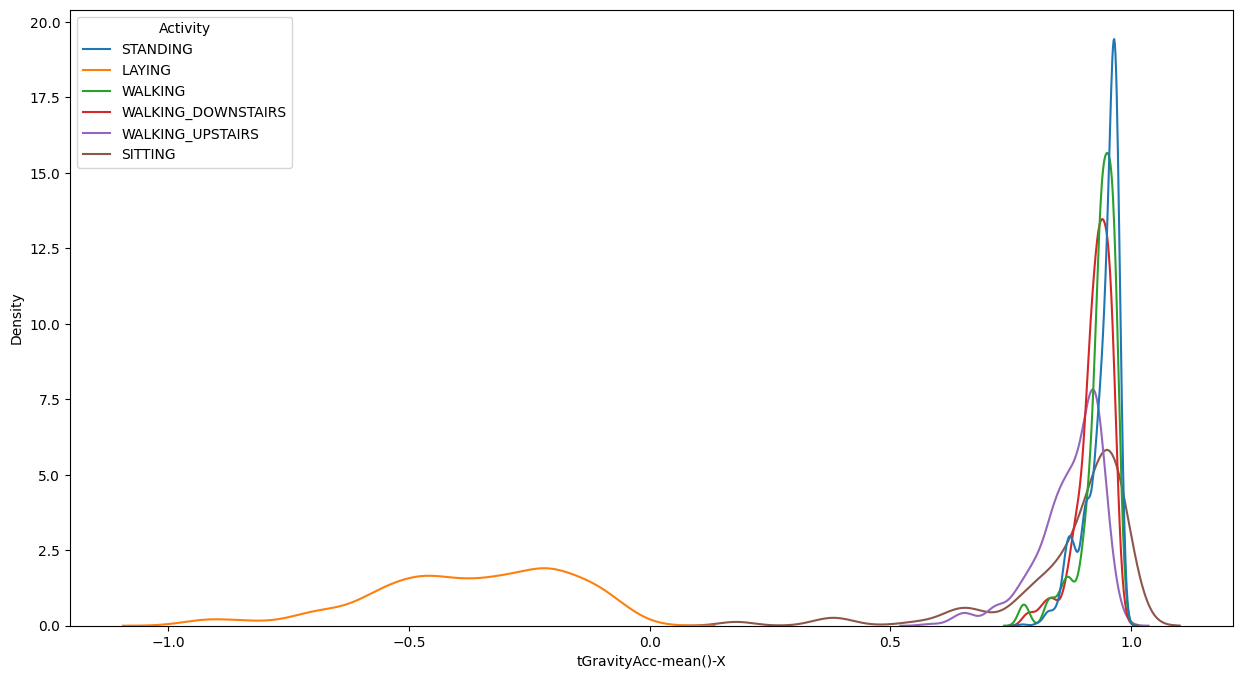

In [611]:
#가장높은것 부터 분석
var = 'tGravityAcc-mean()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

<Axes: xlabel='angle(Y,gravityMean)', ylabel='Density'>

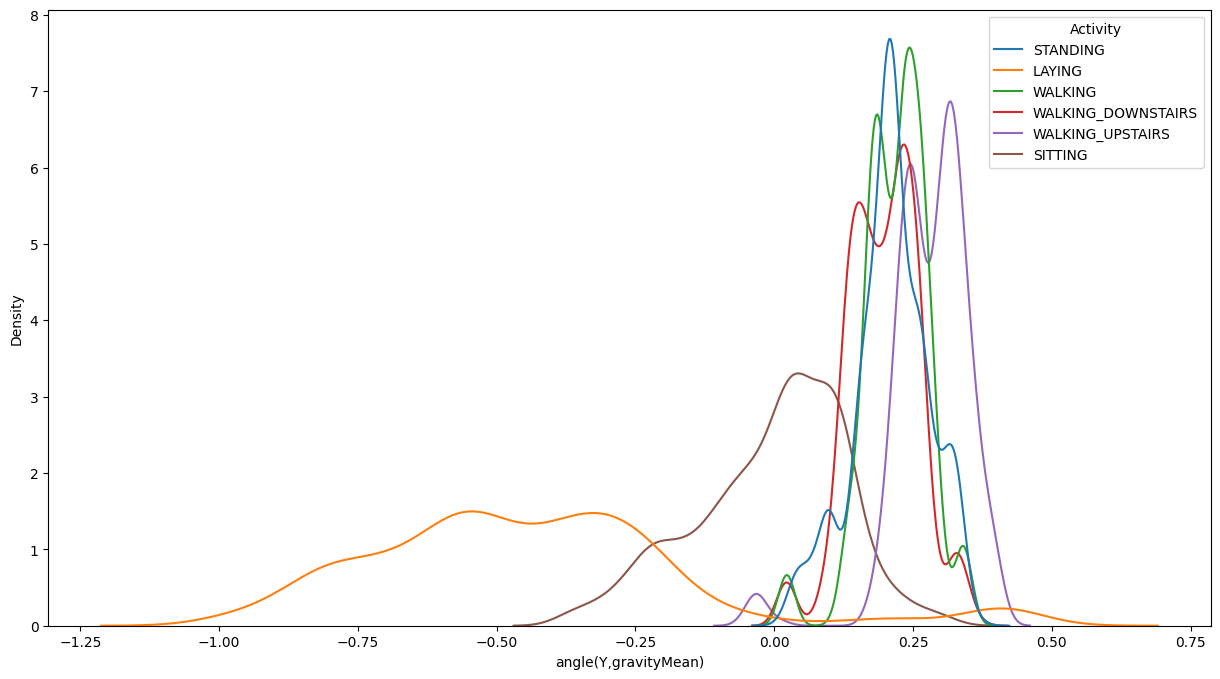

In [617]:
var = 'angle(Y,gravityMean)'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

<Axes: xlabel='tGravityAcc-energy()-X', ylabel='Density'>

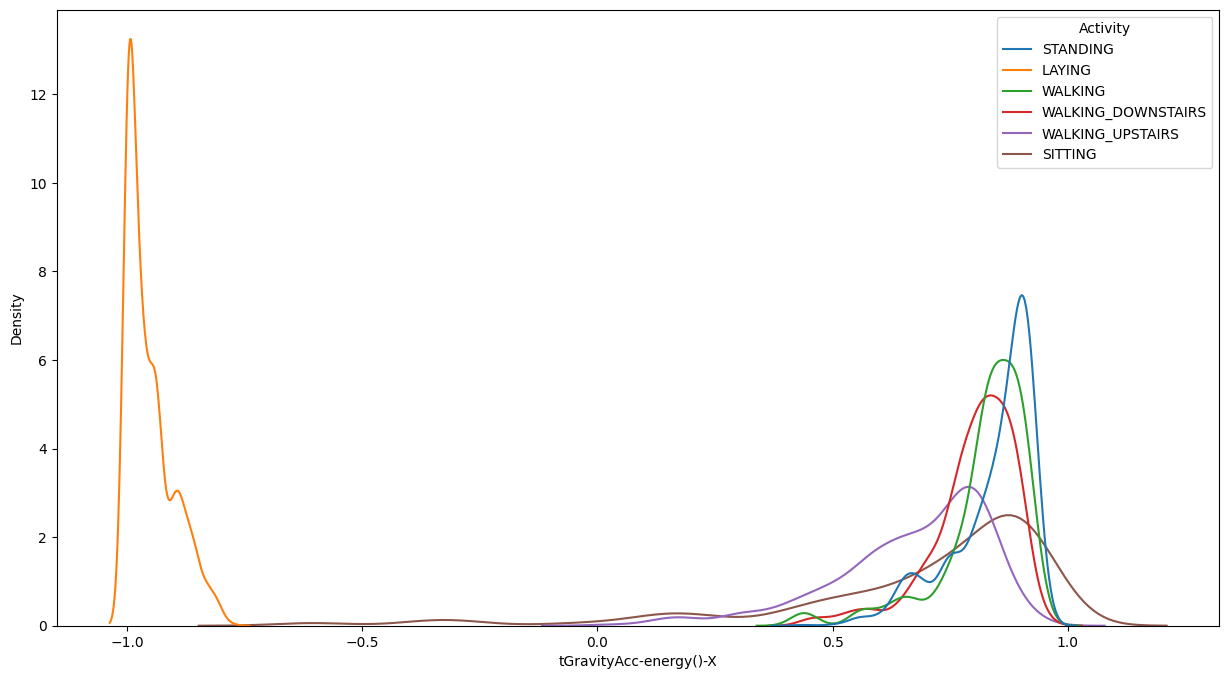

In [619]:
var = 'tGravityAcc-energy()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

<Axes: xlabel='tGravityAcc-max()-X', ylabel='Density'>

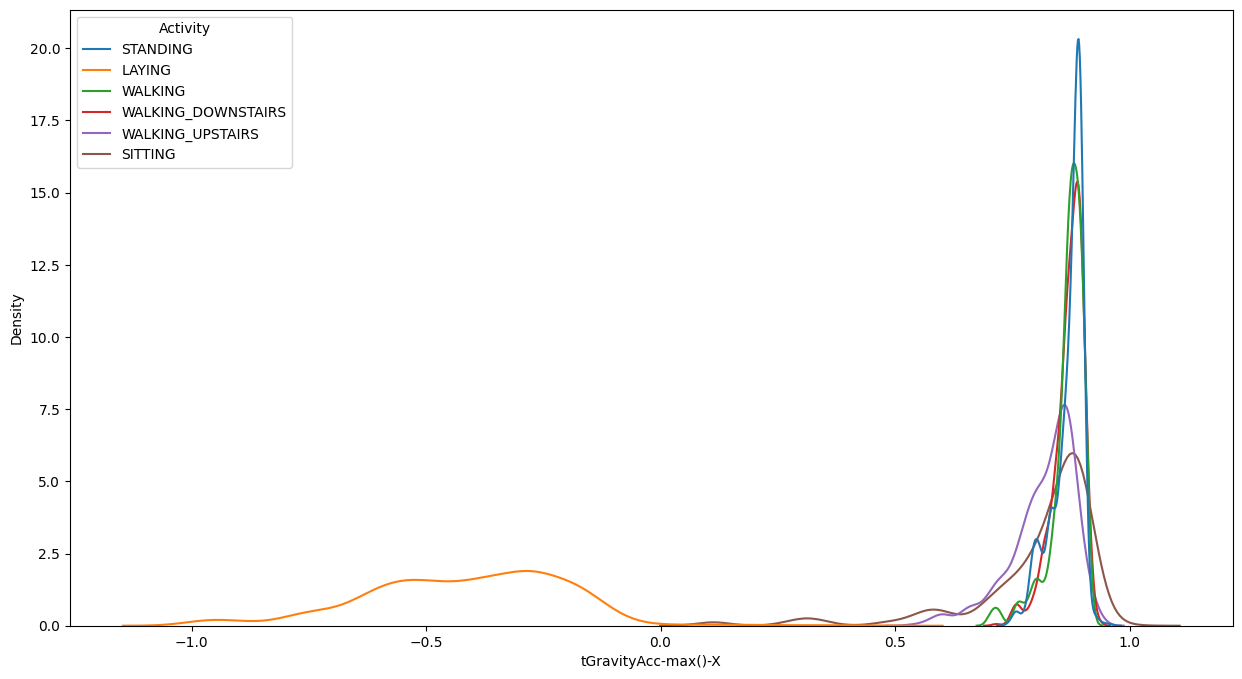

In [623]:
var = 'tGravityAcc-max()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

<Axes: xlabel='tGravityAcc-min()-X', ylabel='Density'>

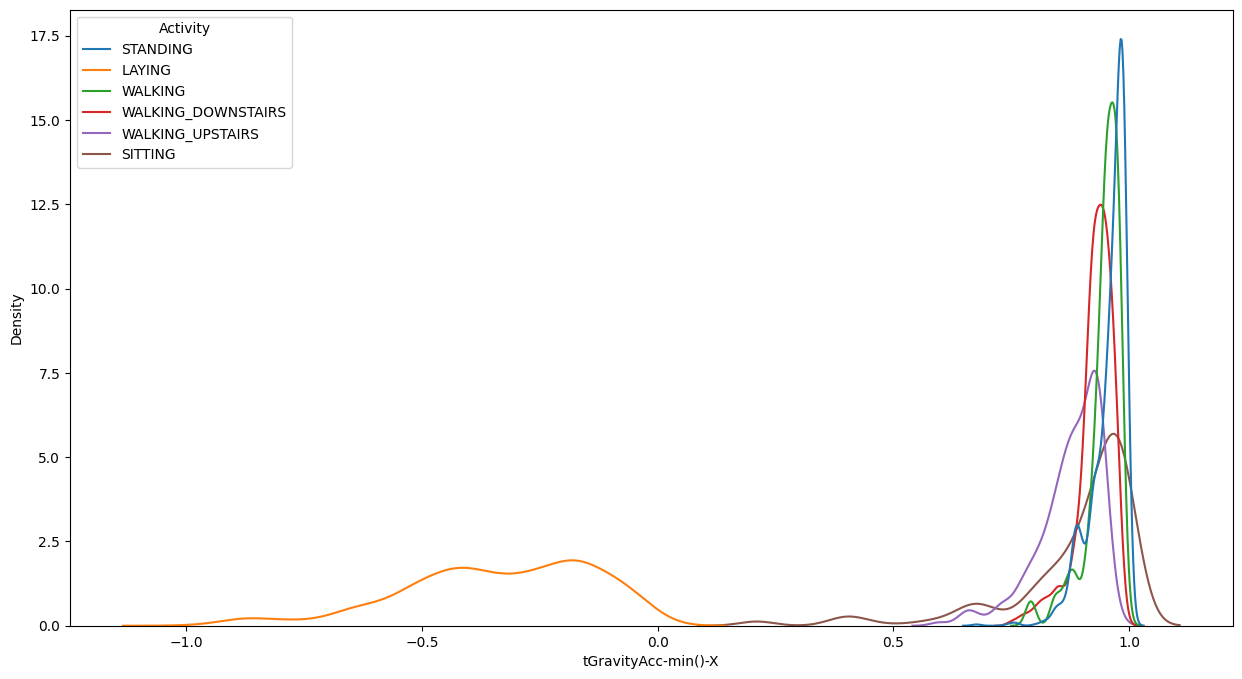

In [625]:
var = 'tGravityAcc-min()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

#### 3) 하위 5개 변수에 대한 분석

<Axes: xlabel='fBodyBodyAccJerkMag-maxInds', ylabel='Density'>

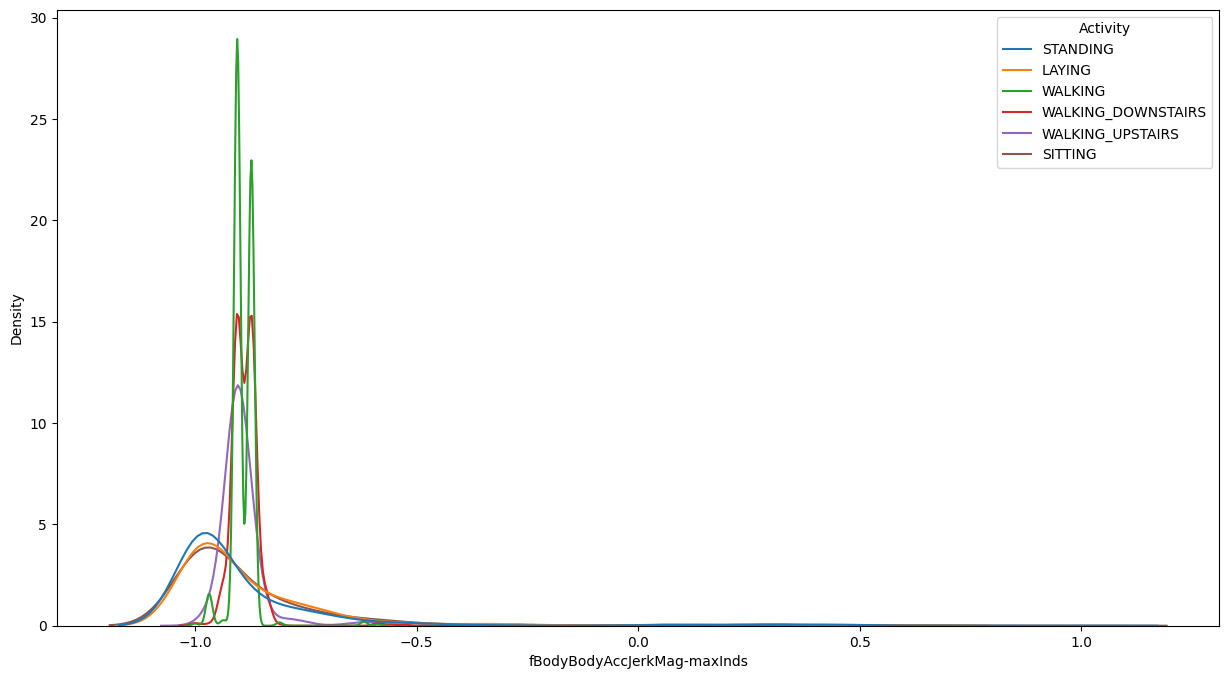

In [627]:
var = 'fBodyBodyAccJerkMag-maxInds'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

<Axes: xlabel='fBodyBodyAccJerkMag-entropy()', ylabel='Density'>

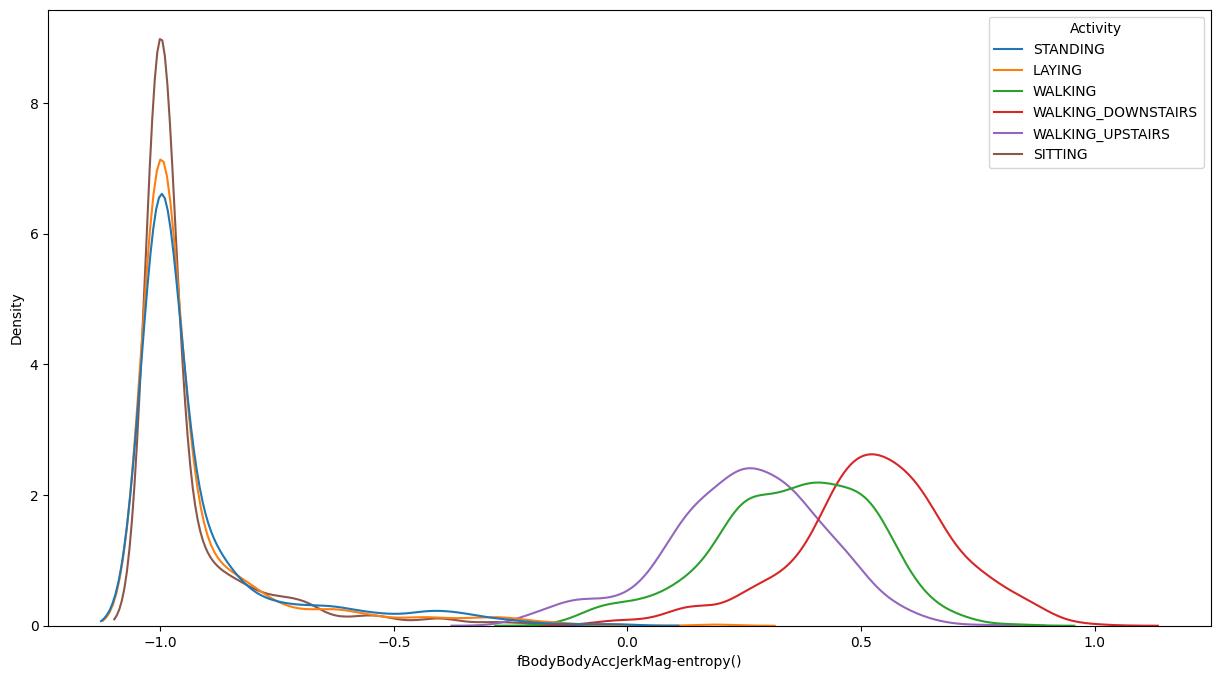

In [629]:
var = 'fBodyBodyAccJerkMag-entropy()'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

<Axes: xlabel='fBodyGyro-bandsEnergy()-57,64.1', ylabel='Density'>

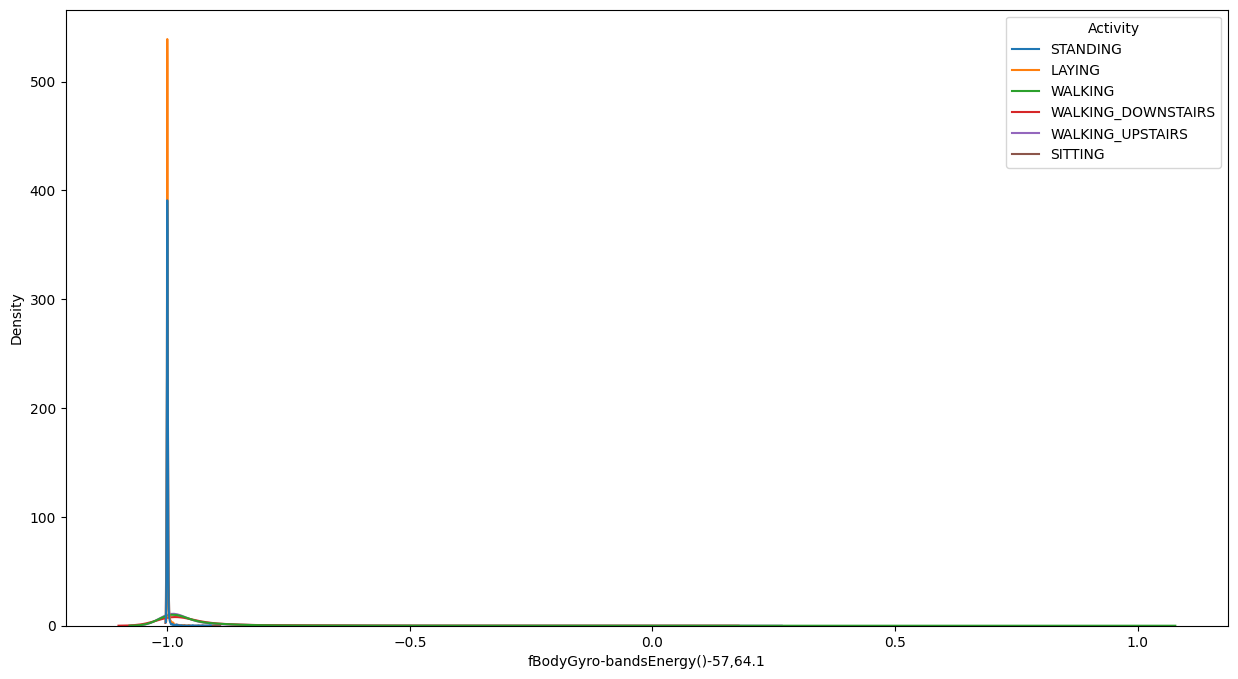

In [631]:
var = 'fBodyGyro-bandsEnergy()-57,64.1'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

<Axes: xlabel='fBodyBodyAccJerkMag-entropy()', ylabel='Density'>

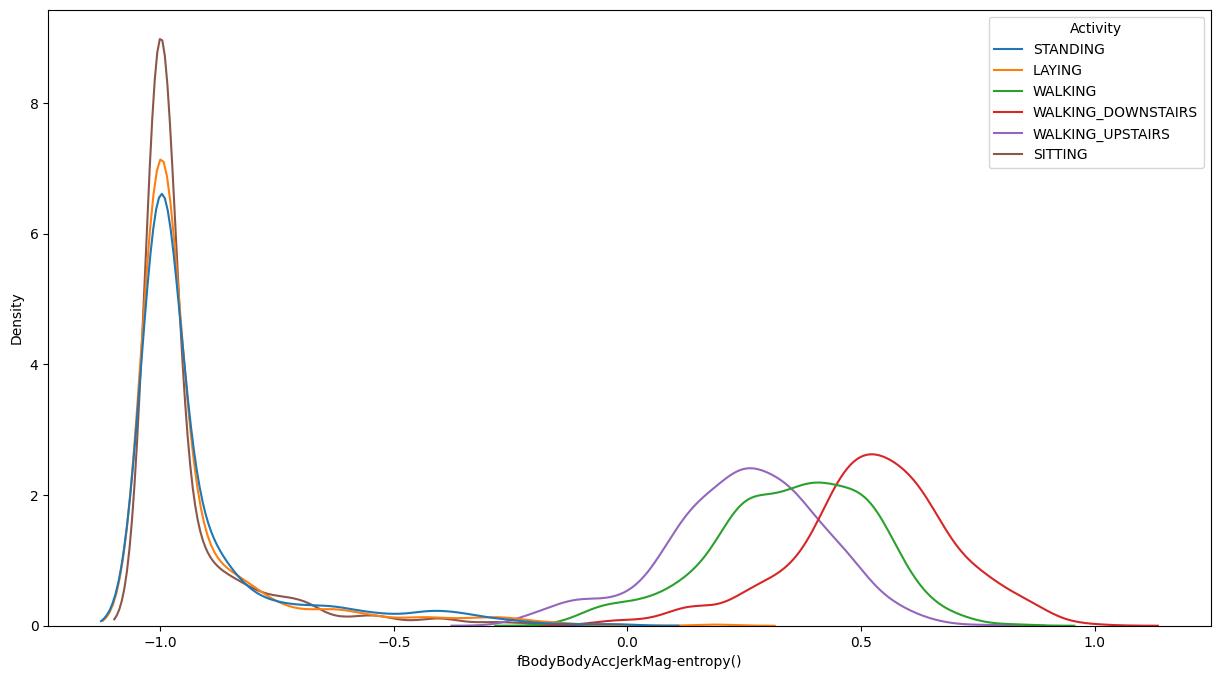

In [633]:
var = 'fBodyBodyAccJerkMag-entropy()'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

<Axes: xlabel='fBodyBodyAccJerkMag-maxInds', ylabel='Density'>

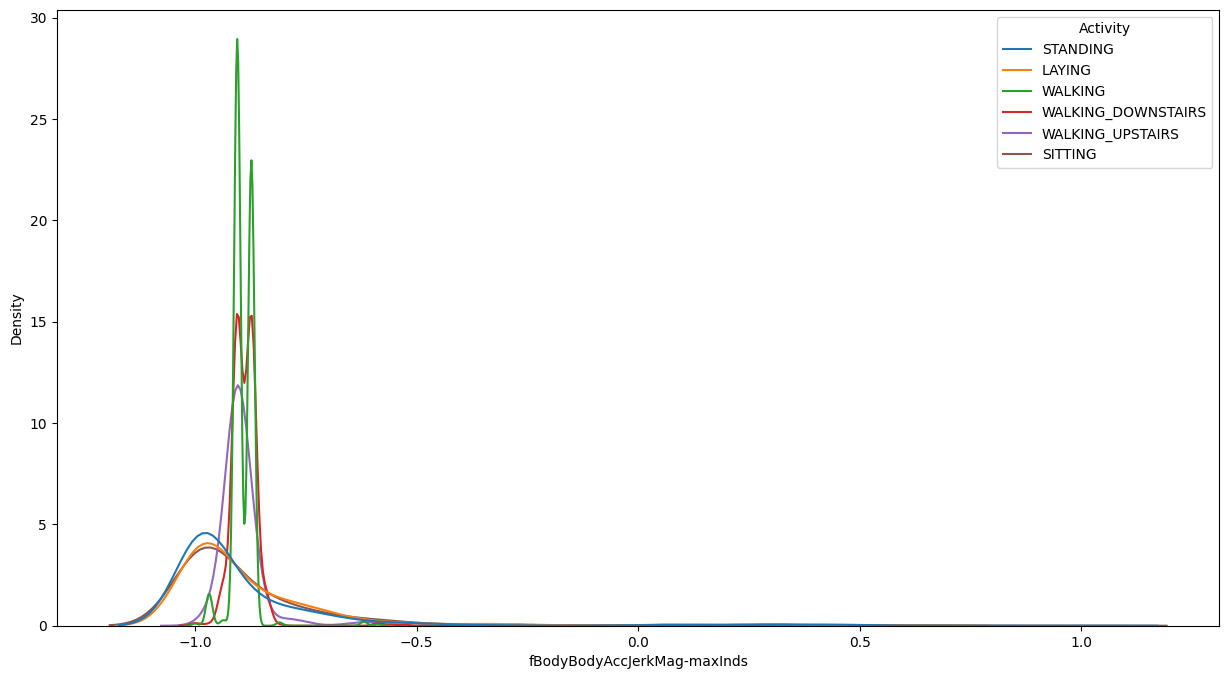

In [635]:
var = 'fBodyBodyAccJerkMag-maxInds'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [639]:
# Activity 변수에 따라 is_dynamic 생성
activity_mapping = {
    'STANDING': 0,
    'SITTING': 0,
    'LAYING': 0,
    'WALKING': 1,
    'WALKING_UPSTAIRS': 1,
    'WALKING_DOWNSTAIRS': 1
}

train['is_dynamic'] = train['Activity'].map(activity_mapping)


In [643]:
train['is_dynamic']

0       0
1       0
2       0
3       1
4       1
       ..
5876    0
5877    1
5878    0
5879    1
5880    0
Name: is_dynamic, Length: 5881, dtype: int64

#### 2) 기본모델 생성

In [660]:
target = 'is_dynamic'
X = train.drop(columns=['Activity', 'is_dynamic'])  # feature
y = train['is_dynamic']  # target

# 데이터 분할 
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

In [662]:
from sklearn.metrics import classification_report, accuracy_score

# 모델 초기화 및 학습
model = RandomForestClassifier()
model.fit(x_train, y_train)
# validation 데이터로 예측
y_pred = model.predict(x_val)

# 성능 평가
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
#출력
print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.9988668555240793
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       811

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



#### 3) 변수중요도 상위 5개 분석

In [664]:
# feature importance 추출
importances = model.feature_importances_
feature_importances = pd.DataFrame(importances, index=x.columns, columns=['importance']).sort_values('importance', ascending=False)

# 상위 5개 변수
top5features = feature_importances.head(5)
print(top5features)

                                 importance
fBodyAccJerk-energy()-X            0.070176
fBodyAccJerk-max()-X               0.050254
fBodyAccJerk-bandsEnergy()-1,16    0.050205
tBodyAccJerk-energy()-X            0.050000
fBodyAccJerk-mean()-X              0.049970


In [666]:
top5features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, fBodyAccJerk-energy()-X to fBodyAccJerk-mean()-X
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   importance  5 non-null      float64
dtypes: float64(1)
memory usage: 80.0+ bytes


In [668]:
top5features 

,importance
fBodyAccJerk-energy()-X,0.070176
fBodyAccJerk-max()-X,0.050254
"fBodyAccJerk-bandsEnergy()-1,16",0.050205
tBodyAccJerk-energy()-X,0.050000
fBodyAccJerk-mean()-X,0.049970


In [670]:
last5feature = feature_importances.tail(5)

In [672]:
last5features

,importance
tBodyGyroMag-arCoeff()3,0.0
tBodyGyroMag-arCoeff()2,0.0
tBodyGyroMag-entropy(),0.0
tGravityAcc-mad()-Y,0.0
tBodyAcc-mean()-X,0.0


<Axes: xlabel='fBodyAccJerk-energy()-X', ylabel='Density'>

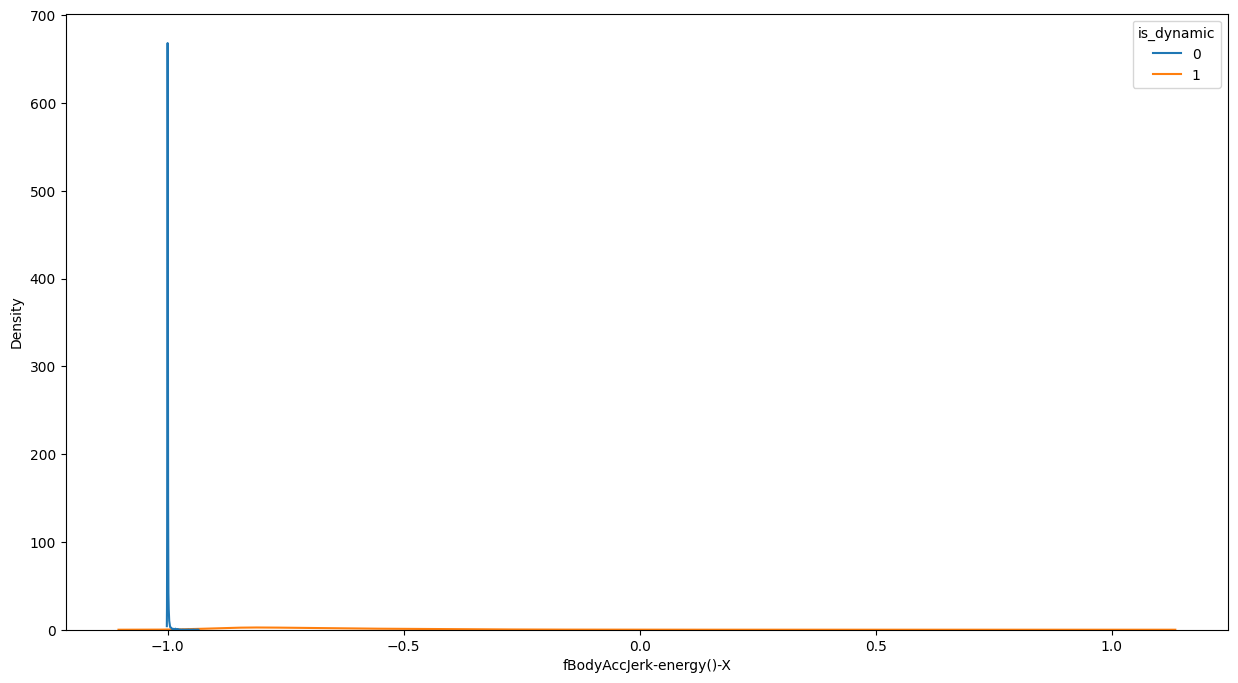

In [682]:
var = 'fBodyAccJerk-energy()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

<Axes: xlabel='fBodyAccJerk-max()-X', ylabel='Density'>

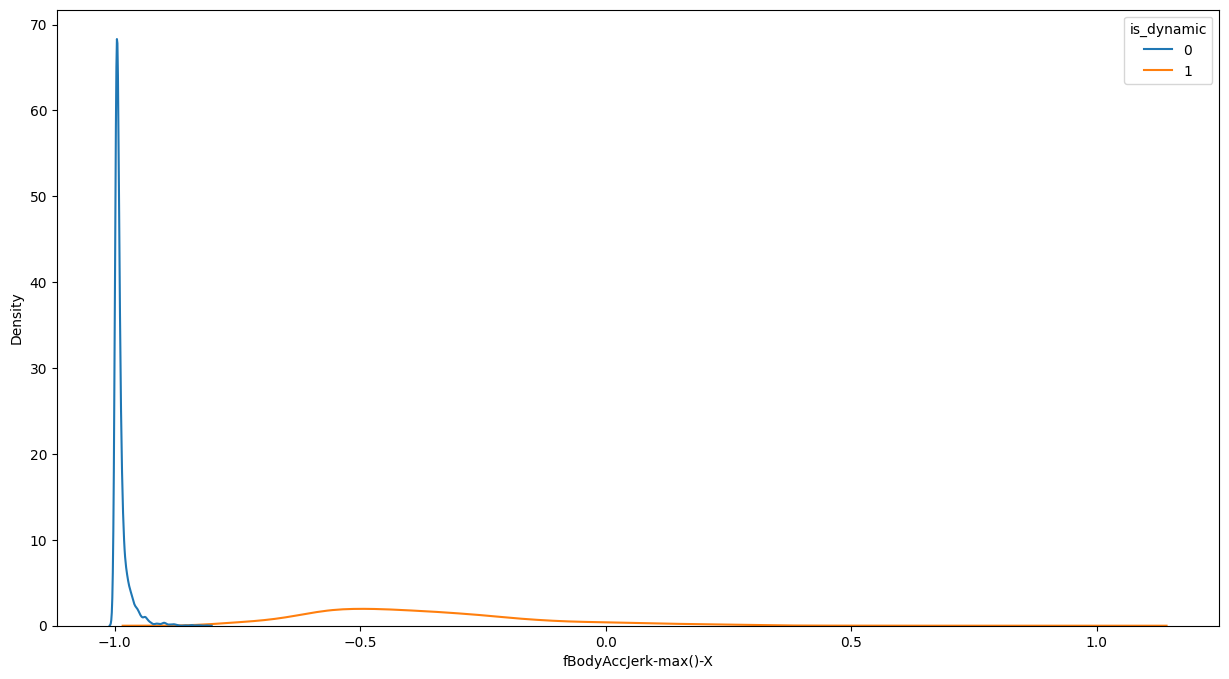

In [684]:
var = 'fBodyAccJerk-max()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

<Axes: xlabel='fBodyAccJerk-bandsEnergy()-1,16', ylabel='Density'>

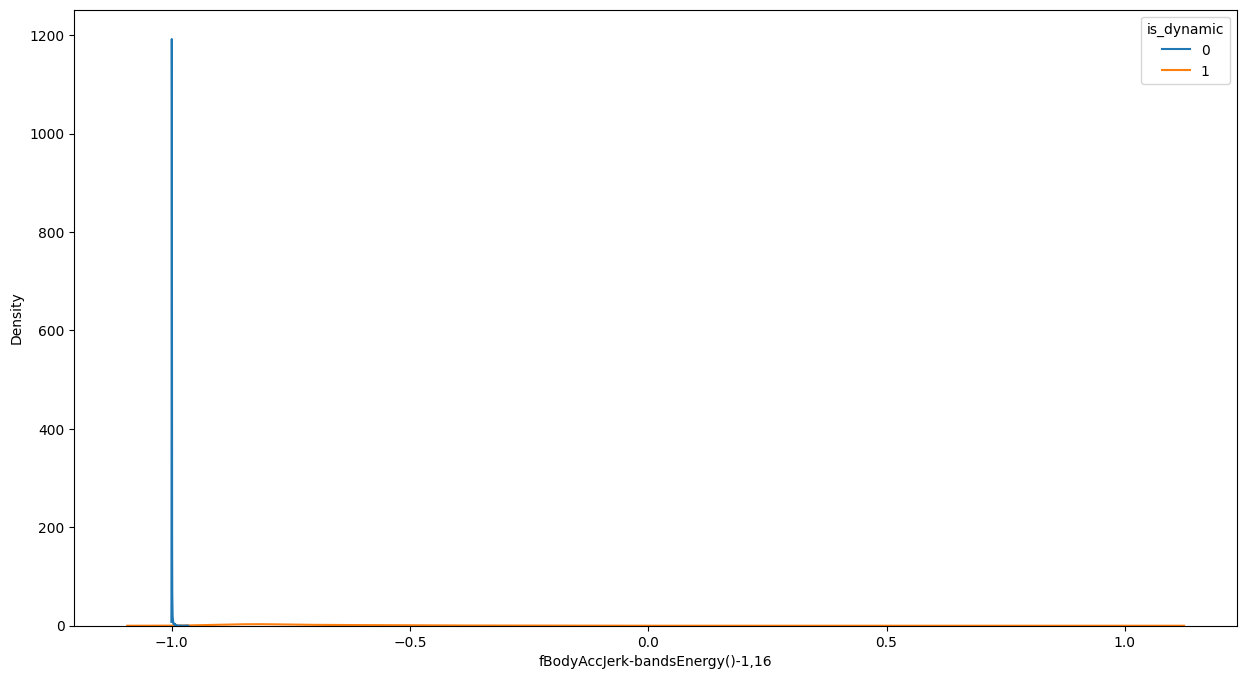

In [686]:
var = 'fBodyAccJerk-bandsEnergy()-1,16'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

<Axes: xlabel='tBodyAccJerk-energy()-X', ylabel='Density'>

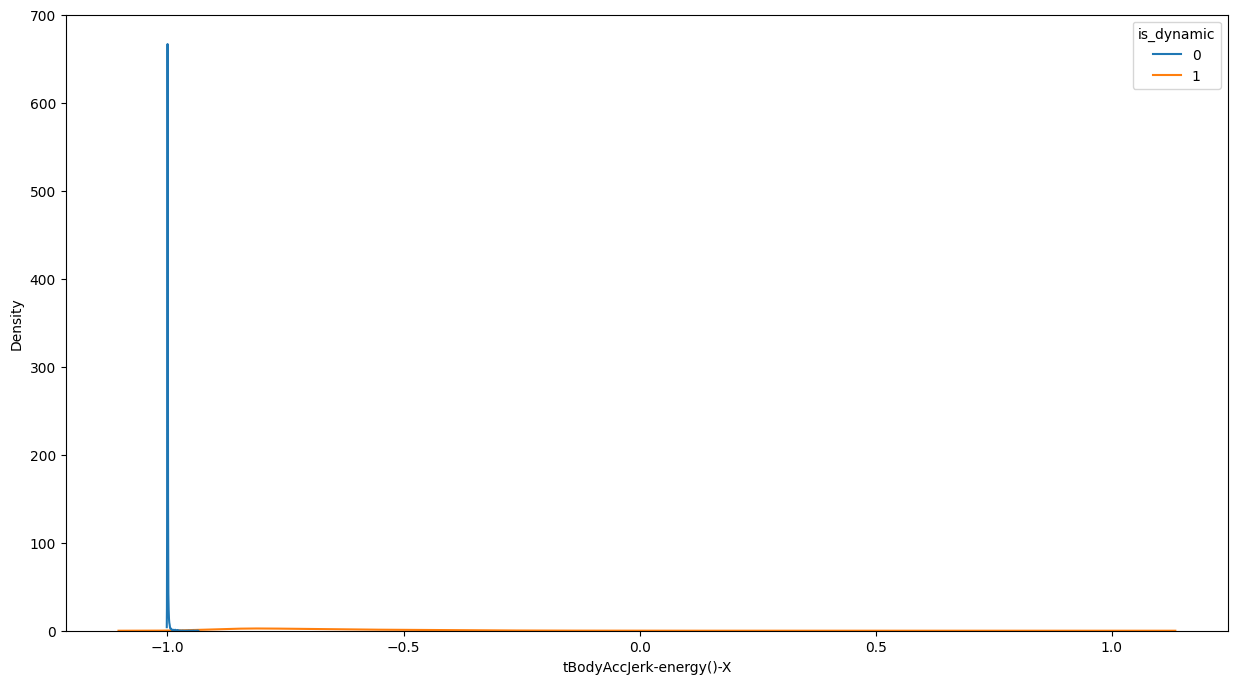

In [688]:
var = 'tBodyAccJerk-energy()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

<Axes: xlabel='fBodyAccJerk-mean()-X', ylabel='Density'>

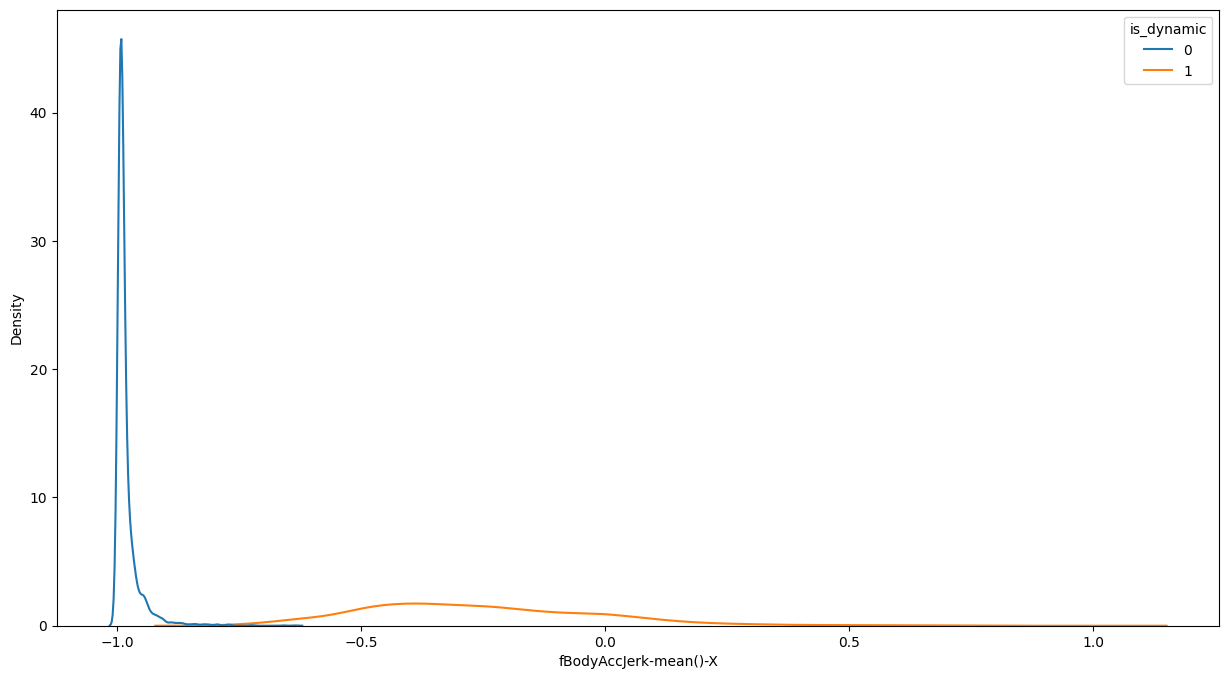

In [690]:
var = 'fBodyAccJerk-mean()-X'
plt.figure(figsize = (15,8))
sns.kdeplot(x=var, data = train, hue =target, common_norm = False)

#### 4) feature 그룹별 분석